In [6]:
import random
import string
from datetime import datetime, timedelta
import psycopg2
from psycopg2 import sql
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.ticker as mtick  # Importa el módulo para formatear el eje
import re # Expresiones regulares
from IPython.display import display


In [8]:
# ------------ FUNCIONES ----------------

# 1. Conexión con BD
# 1.1 Con PSYCOPG2
def conexionBDPostgresSQL():
    # Se omiten los datos de conexión.
    conexion = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="serRIB99",
        host="localhost",
        port="5432"
    )
    return conexion



# 0.
def obtenerDatosBBDD(comandoSQL):
    # Crear conexión y obtener cursor
    conexionBD = conexionBDPostgresSQL() #conexionBDPostgresSQL()
    cursor = conexionBD.cursor()

    # Ejecutar comando y obtener datos
    cursor.execute(comandoSQL)
    registros = cursor.fetchall()

    # Obtener columnas desde el cursor
    columnas = [desc[0] for desc in cursor.description]
    cursor.close()
    conexionBD.close()
    return registros, columnas


# 1. Obtener datos Generación (procesados)
def obtenerDataframeDemanda():
  comandoSQL_Demanda = "SELECT * FROM tfm.demanda_procesada ORDER BY \"fecha\" ASC"
  datosDemanda, columnasDemanda =  obtenerDatosBBDD(comandoSQL_Demanda)
  df_Demanda = pd.DataFrame(datosDemanda, columns=columnasDemanda)
  return df_Demanda


def crearColumnasAnyoMesDia(dataset):
  # Crear nuevas columnas
  dataset['Año'] = dataset['fecha'].dt.year
  dataset['Mes'] = dataset['fecha'].dt.month
  dataset['Dia'] = dataset['fecha'].dt.day
  dataset['DiaSemana'] = dataset['fecha'].dt.weekday + 1  # +1 para que 1=Lunes, ..., 7=Domingo
  return dataset




def generarGraficasDistribucion_2filas_gen(dataset,fecha,mes,dia_semana,columna):

    diccionarioMeses = {
        1: 'Enero',
        2: 'Febrero',
        3: 'Marzo',
        4: 'Abril',
        5: 'Mayo',
        6: 'Junio',
        7: 'Julio',
        8: 'Agosto',
        9: 'Septiembre',
        10: 'Octubre',
        11: 'Noviembre',
        12: 'Diciembre'
    }
    diccionarioDiaSemana = {
        1: 'Lunes',
        2: 'Martes',
        3: 'Miércoles',
        4: 'Jueves',
        5: 'Viernes',
        6: 'Sábado',
        7: 'Domingo'
    }
    # Ajustar tamaño de la figura para 1 fila de 3 gráficos y 1 fila de 1 gráfico que ocupe todo el ancho
    fig = plt.figure(figsize=(15, 10), dpi=300)
    # Crear subplots manualmente
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=3, rowspan=1)  # Este eje ocupa toda la segunda fila
    
    # Generación por día de la semana
    
    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado_dia = dataset.groupby(dia_semana)[columna].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado_dia[columna].mean()
    
    etiquetas_traducidas_dia = [diccionarioDiaSemana.get(label, label) for label in df_agrupado_dia[dia_semana]]

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado_dia[columna]))
    ax1.bar(bar_positions, df_agrupado_dia[columna], color='lightcoral')

    # Añadir la línea de la media global de los valores agrupados
    ax1.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    ax1.legend(loc='upper right', framealpha=0.5, fontsize='small')


    # Añadir etiquetas y título
    #ax1.xlabel(columna_para_agrupar.capitalize())
    #ax1.ylabel('Valor generación media')
    ax1.set_title(f'Generación por día de la semana de: {columna.upper()}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    ax1.set_xticks(ticks=bar_positions, labels=etiquetas_traducidas_dia, rotation=45, ha='right')

    # Generación por mes
    
    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado_mes = dataset.groupby(mes)[columna].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado_mes[columna].mean()

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado_mes[columna]))
    ax2.bar(bar_positions, df_agrupado_mes[columna], color='khaki')

    # Añadir la línea de la media global de los valores agrupados
    ax2.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    ax2.legend(loc='upper right', framealpha=0.5, fontsize='small')

    etiquetas_traducidas_mes = [diccionarioMeses.get(label, label) for label in df_agrupado_mes[mes]]

    # Añadir etiquetas y título
    #ax2.xlabel(columna_para_agrupar.capitalize())
    #ax2.ylabel('Valor generación media')
    ax2.set_title(f'Generación por mes del año de: {columna.upper()}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    #plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas, rotation=45, ha='right')


    # Histograma
    sns.histplot(dataset[columna], kde=True, ax=ax3,  color='paleturquoise')
    ax3.set_title(f'Histograma de: {columna.upper()}')
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')
    #ax2.tick_params(axis='x', labelsize=8.5) # Sólo si se solapan los textos
    #ax2.set_ylabel('Etiqueta EJE Y')
    
    #Serie temportal

    if not pd.api.types.is_datetime64_any_dtype(dataset['fecha']):
        dataset['fecha'] = pd.to_datetime(dataset['fecha'])

    ax4.plot(dataset['fecha'], dataset[columna], linestyle='-', color='plum')
    ax4.set_title(f'Serie Temporal de: {columna.upper()}')
    ax4.set_xlabel('Fecha')
    ax4.set_ylabel('Valor')

    # Establecer el formato del eje x para mostrar cada año
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Añadir líneas verticales punteadas en cada año
    years = mdates.YearLocator()  # Localizador de años
    for year_loc in years.tick_values(dataset['fecha'].min(), dataset['fecha'].max()):
        ax4.axvline(x=year_loc, color='gray', linestyle='dashed', linewidth=1)

    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)  # Rotar las etiquetas si es necesario para mejor visualización
    
    # Use the pyplot interface to change just one subplot...
    
    plt.sca(ax2)
    plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas_mes, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'demanda_{columna}.jpg')
    plt.show()



## Demanda
Ahora que ya hemos creado todas las funciones que vamos a usar en este análisis, vamos a importar los datos a un dataframe y empezar a trabajar con ellos.

In [10]:
# 1. Generación
dataframeDemanda = obtenerDataframeDemanda()
# Asegurar que todos los dataframe tiene un campo llamado "fecha"
dataframeDemanda = dataframeDemanda.rename(columns={'fechaDemanda': 'fecha'})
dataframeDemanda.dtypes

fecha           datetime64[ns]
valordemanda            object
dtype: object

Como los tipos de datos importados desde la tabla de PostgreSQLno estan bien, es necesario transformar la columna valor demanda a valor numérico

In [12]:
dataframeDemanda["valordemanda"] = dataframeDemanda["valordemanda"].apply(pd.to_numeric, errors='coerce')
dataframeDemanda.dtypes

fecha           datetime64[ns]
valordemanda           float64
dtype: object

Ahora que ya hemos ajustado los tipos de datos vamos, vamos a usar la función describe para ver un resumen de los datos del dataframe

In [14]:
dataframeDemanda.describe(include='all')

,fecha,valordemanda
count,5114,5114.000000
mean,2017-12-31 12:00:00,711113.494583
min,2011-01-01 00:00:00,489067.621000
25%,2014-07-02 06:00:00,661339.597250
50%,2017-12-31 12:00:00,715176.577000
75%,2021-07-01 18:00:00,761458.510250
max,2024-12-31 00:00:00,925838.099000
std,NaN,72233.271611


In [21]:
print("Dimensiones: ", dataframeDemanda.shape)

Dimensiones:  (5114, 2)


In [23]:
# Comprobar si hay duplicados
duplicados = dataframeDemanda.duplicated()

# Mostrar los registros duplicados (esto incluye la primera aparición)
df_duplicados = dataframeDemanda[duplicados]

# Mostrar el resultado
print("Registros duplicados:")
print(df_duplicados)

Registros duplicados:
Empty DataFrame
Columns: [fecha, valordemanda]
Index: []


In [25]:
dataframeDemanda = crearColumnasAnyoMesDia(dataframeDemanda)
dataframeDemanda.head()

,fecha,valordemanda,Año,Mes,Dia,DiaSemana
0,2011-01-01,605986.216,2011,1,1,6
1,2011-01-02,641856.087,2011,1,2,7
2,2011-01-03,801297.365,2011,1,3,1
3,2011-01-04,833253.263,2011,1,4,2
4,2011-01-05,803475.573,2011,1,5,3


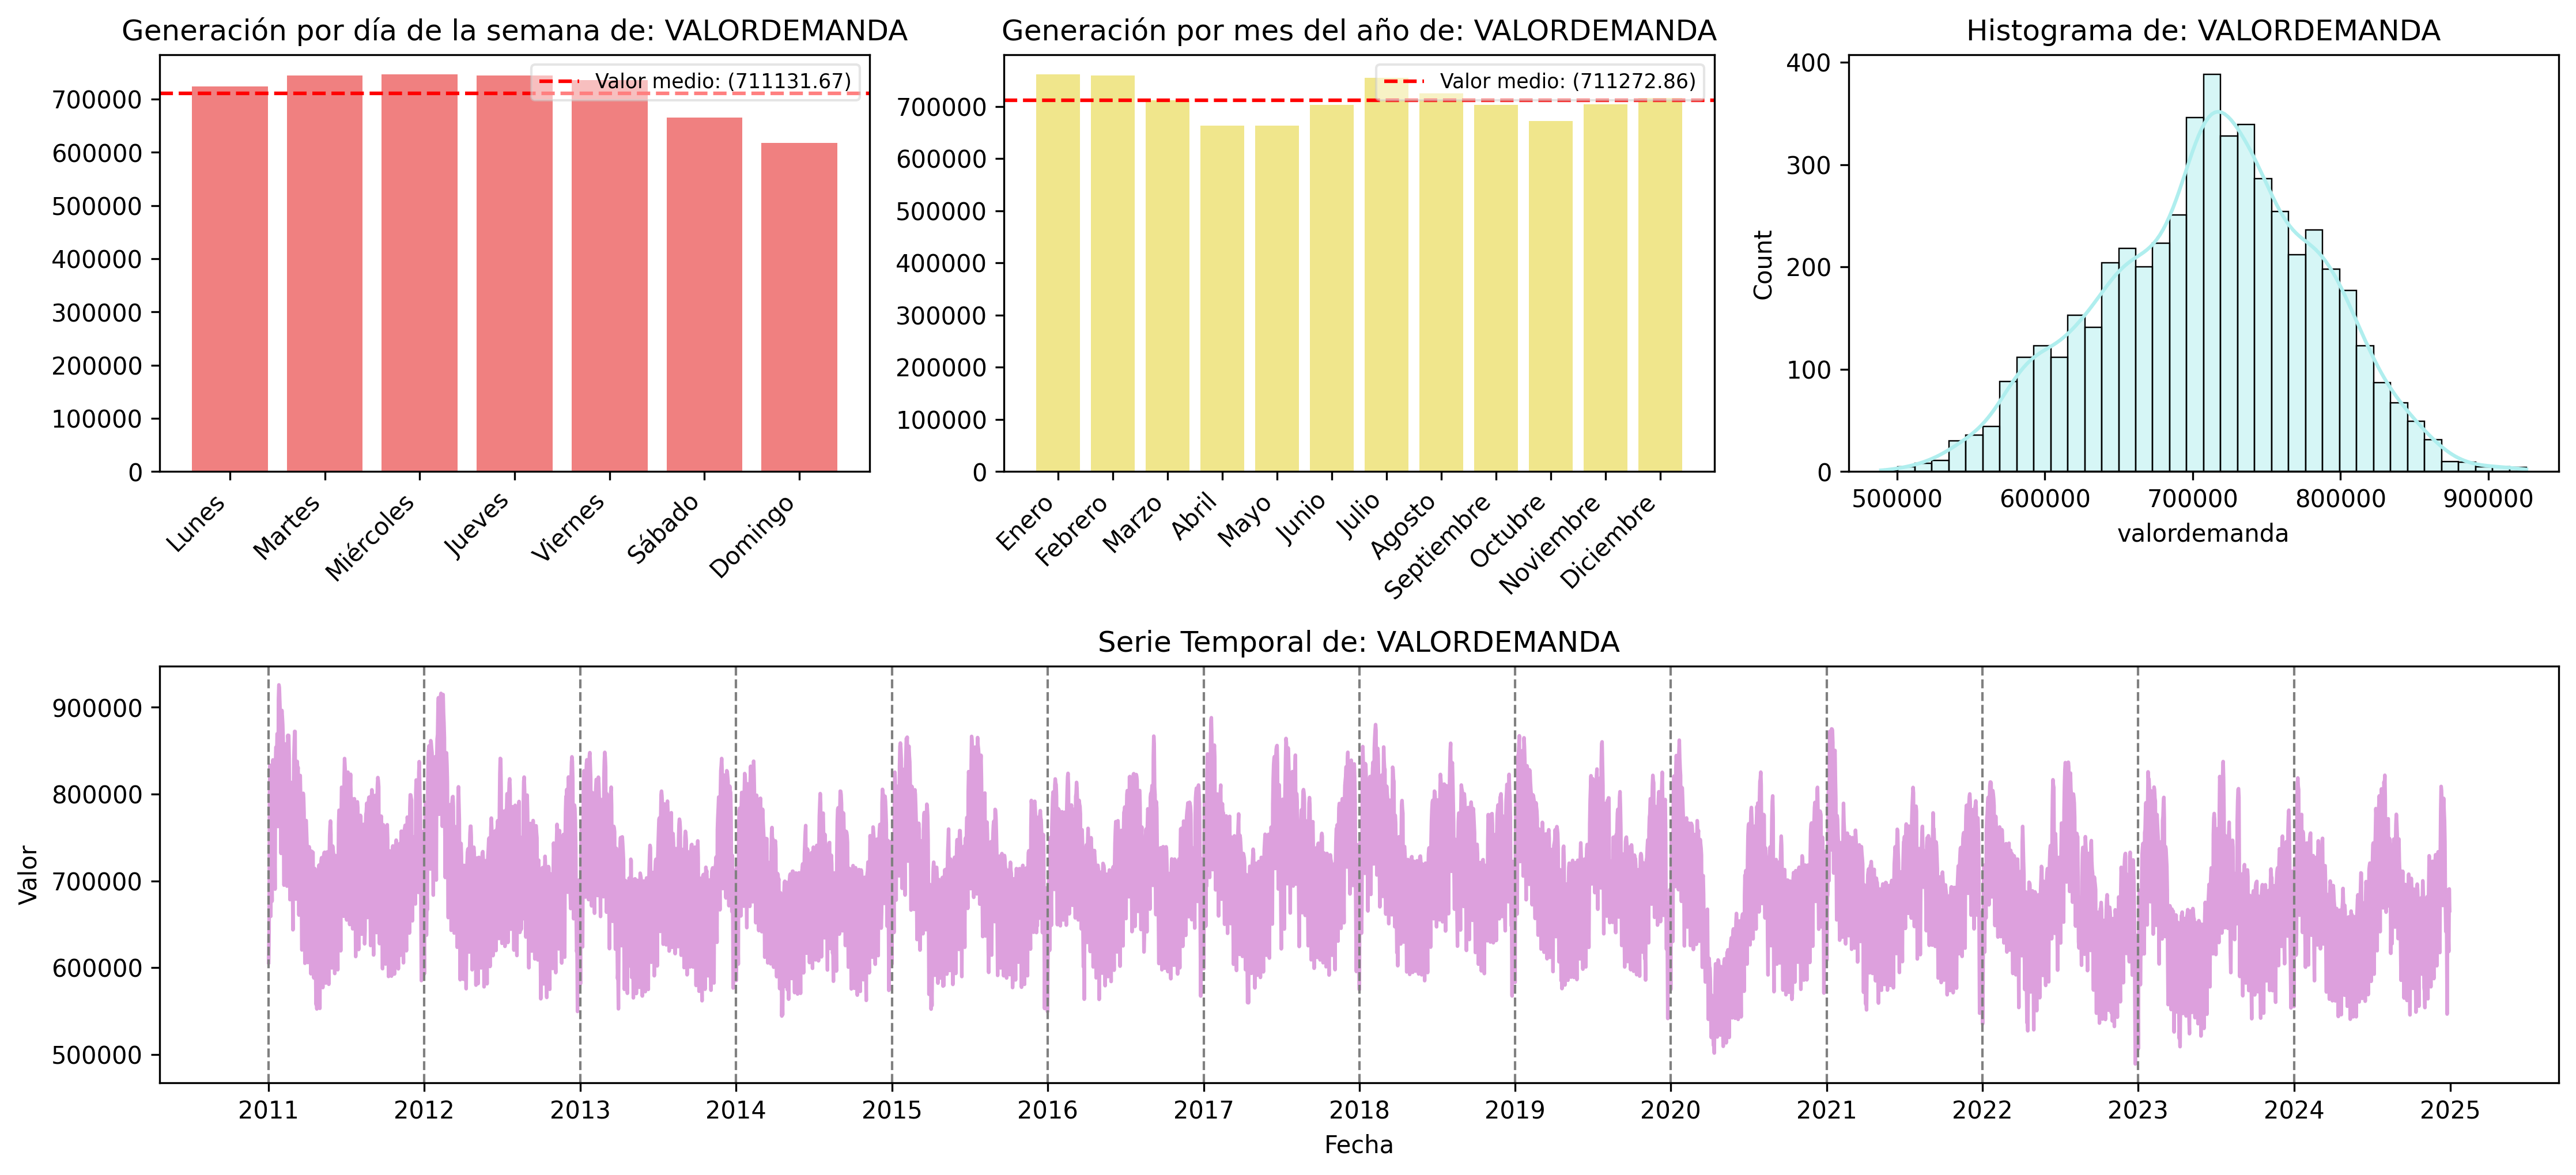

In [27]:
generarGraficasDistribucion_2filas_gen(dataframeDemanda,'fecha','Mes','DiaSemana','valordemanda')